In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
!pip install xgboost

In [55]:
# Data
import numpy as np
import pandas as pd

# Modeling
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
#from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_formats = ['retina']
sns.set_style("white")

In [56]:
# Import pickled df with all data
df = pd.read_pickle('./all_data.pkl')

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54262 entries, 0 to 54261
Data columns (total 10 columns):
country_name                54262 non-null object
region_name                 54262 non-null object
income_group_name           54262 non-null object
fiscal_year                 54262 non-null int64
HDI_Change                  54262 non-null float64
assistance_category_name    54262 non-null object
implementing_agency_name    54262 non-null object
dac_category_name           54262 non-null object
dac_sector_name             54262 non-null object
constant_amount             54262 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 4.1+ MB


In [58]:
df.head()

,country_name,region_name,income_group_name,fiscal_year,HDI_Change,assistance_category_name,implementing_agency_name,dac_category_name,dac_sector_name,constant_amount
0,Afghanistan,South and Central Asia,Low Income Country,2003,0.01,Economic,Department of Agriculture,Agriculture,Agriculture,81354
1,Afghanistan,South and Central Asia,Low Income Country,2003,0.01,Economic,Department of Agriculture,Commodity Assistance,Developmental Food Aid/Food Security Assistance,6971711
2,Afghanistan,South and Central Asia,Low Income Country,2003,0.01,Economic,Department of Agriculture,Education,Basic Education,4392782
3,Afghanistan,South and Central Asia,Low Income Country,2003,0.01,Economic,Department of Agriculture,Other,General Environmental Protection,34632
4,Afghanistan,South and Central Asia,Low Income Country,2003,0.01,Economic,Department of Health and Human Services,Governance,"Conflict, Peace, and Security",915696


In [59]:
# Drop rows where 'dac_category_name' is 'Administrative Costs'

df.loc[(df['dac_category_name'] != 'Administrative Costs') & (df['dac_category_name'] != 'Other')]


,country_name,region_name,income_group_name,fiscal_year,HDI_Change,assistance_category_name,implementing_agency_name,dac_category_name,dac_sector_name,constant_amount
0,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Agriculture,Agriculture,Agriculture,81354
1,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Agriculture,Commodity Assistance,Developmental Food Aid/Food Security Assistance,6971711
2,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Agriculture,Education,Basic Education,4392782
4,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Health and Human Services,Governance,"Conflict, Peace, and Security",915696
5,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Health and Human Services,Health and Population,Basic Health,3976353
6,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of Labor,Governance,"Conflict, Peace, and Security",3924413
7,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of State,Economic Growth,Business and Other Services,217919
8,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of State,Governance,"Conflict, Peace, and Security",14781954
9,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of State,Governance,Government and Civil Society,1954992
10,Afghanistan,South and Central Asia,Low Income Country,2003,0.010,Economic,Department of State,Humanitarian,Emergency Response,61698247


In [8]:
#Remove observations for countries that received aid for fewer than 3 years?
#num_years_per_country = df.groupby(['country_name'])['fiscal_year'].nunique().reset_index()
#num_years_per_country.info()

In [9]:
# Not super useful

#num_years_per_country.loc[num_years_per_country['fiscal_year'] >= 5]

In [10]:
#Remove observations for countries that received aid in a year for fewer than 10 sectors
categories_per_countryyear = df.groupby(['country_name', 'fiscal_year'])['dac_category_name'].nunique().reset_index()
categories_per_countryyear.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4051 entries, 0 to 4050
Data columns (total 3 columns):
country_name         4051 non-null object
fiscal_year          4051 non-null int64
dac_category_name    4051 non-null int64
dtypes: int64(2), object(1)
memory usage: 95.0+ KB


In [11]:
categories_per_countryyear = categories_per_countryyear.loc[
    categories_per_countryyear['dac_category_name'] >= 2
].drop(columns = 'dac_category_name')

In [12]:
categories_per_countryyear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3512 entries, 0 to 4050
Data columns (total 2 columns):
country_name    3512 non-null object
fiscal_year     3512 non-null int64
dtypes: int64(1), object(1)
memory usage: 82.3+ KB


In [13]:
df = pd.merge(df, categories_per_countryyear, 
              how = 'inner', 
              on=['country_name', 'fiscal_year'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49840 entries, 0 to 49839
Data columns (total 10 columns):
country_name                49840 non-null object
region_name                 49840 non-null object
income_group_name           49840 non-null object
fiscal_year                 49840 non-null int64
HDI_Change                  49840 non-null float64
assistance_category_name    49840 non-null object
implementing_agency_name    49840 non-null object
dac_category_name           49840 non-null object
dac_sector_name             49840 non-null object
constant_amount             49840 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 4.2+ MB


In [15]:
#df['Agency_and_Category'] = df['implementing_agency_name'] + ': ' + df['dac_category_name']

In [16]:
#df.head(10)

In [17]:
# Transform df so entries for year/country are grouped (want one row per country per year)
df = df.groupby(['region_name', 'income_group_name', 'fiscal_year', 
                 'country_name', 'HDI_Change', 'dac_category_name']
               )['constant_amount'].sum().unstack('dac_category_name').reset_index()
df.head()

dac_category_name,region_name,income_group_name,fiscal_year,country_name,HDI_Change,Agriculture,Commodity Assistance,Economic Growth,Education,Governance,Health and Population,Humanitarian,Infrastructure,Other
0,East Asia and Oceania,High Income Country,1994,Korea Republic,0.011,NaN,NaN,NaN,NaN,138364.0,NaN,NaN,NaN,2323513.0
1,East Asia and Oceania,High Income Country,1998,Korea Republic,-0.003,NaN,NaN,293961.0,NaN,NaN,NaN,NaN,146784.0,185019.0
2,East Asia and Oceania,High Income Country,1999,Korea Republic,0.011,NaN,NaN,495862.0,NaN,NaN,NaN,NaN,619495.0,18140.0
3,East Asia and Oceania,High Income Country,2000,Korea Republic,0.009,NaN,NaN,721727.0,NaN,277427.0,NaN,NaN,NaN,NaN
4,East Asia and Oceania,High Income Country,2001,China (P.R. Hong Kong),0.008,NaN,NaN,NaN,NaN,69090.0,NaN,16208.0,NaN,NaN


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Data columns (total 14 columns):
region_name              3512 non-null object
income_group_name        3512 non-null object
fiscal_year              3512 non-null int64
country_name             3512 non-null object
HDI_Change               3512 non-null float64
Agriculture              1234 non-null float64
Commodity Assistance     1303 non-null float64
Economic Growth          1734 non-null float64
Education                1261 non-null float64
Governance               3447 non-null float64
Health and Population    1842 non-null float64
Humanitarian             2087 non-null float64
Infrastructure           1620 non-null float64
Other                    3003 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 384.2+ KB


In [19]:
# Fill all NaNs with 0
df.fillna(0, inplace=True)

### Split data into data/target categories

In [20]:
# Define small input df
X = df.loc[:, df.columns != 'HDI_Change']

# Define Targets
y = df['HDI_Change']

### Drop Columns

In [21]:
# Drop 'fiscal_year' column
X.drop(['fiscal_year'], axis=1, inplace=True) 
#        'country_name', 
#        'Action Relating To Debt', 
#        'Administration and Oversight', 
#        'Operating Expenses', 
#        'Unallocated/ Unspecified', 
#        'Other Multisector', 
#        'Transport and Storage'

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


### Transform categorical variables

In [22]:
# Transform 'country_name', 'region_name', 'implementing_agency_name', 
# and 'USG_sector_name' using get_dummies

X = pd.concat([X, pd.get_dummies(X[['country_name', 'region_name']])], axis=1)
X.drop(['country_name', 'region_name'], axis=1, inplace=True)

In [23]:
# Change assistance_category_name to Economic_Assistance (0 or 1)
#X['Economic_Assistance'] = X.assistance_category_name.apply(lambda x: 1 if x == 'Economic' else 0)

# Drop assistance_category_name column
#X.drop('assistance_category_name', axis=1, inplace=True)

In [24]:
# Encode Income Group Name:
# 1 = Low Income Country
# 2 = Lower Middle Income Country
# 3 = Upper Middle Income Country
# 4 = High Income Country

def rankIncomes(incomeClass):
    if incomeClass == 'Low Income Country':
        return 0
    elif incomeClass == 'Lower Middle Income Country':
        return 1
    elif incomeClass == 'Upper Middle Income Country':
        return 2
    else:
        return 3

# Apply function and drop original column
X['Country_Income_Class'] = X.income_group_name.apply(rankIncomes)
X.drop('income_group_name', axis=1, inplace=True)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3512 entries, 0 to 3511
Columns: 198 entries, Agriculture to Country_Income_Class
dtypes: float64(9), int64(1), uint8(188)
memory usage: 919.2 KB


In [26]:
list(X.columns)

['Agriculture',
 'Commodity Assistance',
 'Economic Growth',
 'Education',
 'Governance',
 'Health and Population',
 'Humanitarian',
 'Infrastructure',
 'Other',
 'country_name_Afghanistan',
 'country_name_Albania',
 'country_name_Algeria',
 'country_name_Angola',
 'country_name_Antigua and Barbuda',
 'country_name_Argentina',
 'country_name_Armenia',
 'country_name_Australia',
 'country_name_Austria',
 'country_name_Azerbaijan',
 'country_name_Bahamas',
 'country_name_Bahrain',
 'country_name_Bangladesh',
 'country_name_Barbados',
 'country_name_Belarus',
 'country_name_Belgium',
 'country_name_Belize',
 'country_name_Benin',
 'country_name_Bhutan',
 'country_name_Bolivia',
 'country_name_Bosnia and Herzegovina',
 'country_name_Botswana',
 'country_name_Brazil',
 'country_name_Bulgaria',
 'country_name_Burkina Faso',
 'country_name_Burma (Myanmar)',
 'country_name_Burundi',
 'country_name_Cabo Verde',
 'country_name_Cambodia',
 'country_name_Cameroon',
 'country_name_Canada',
 'countr

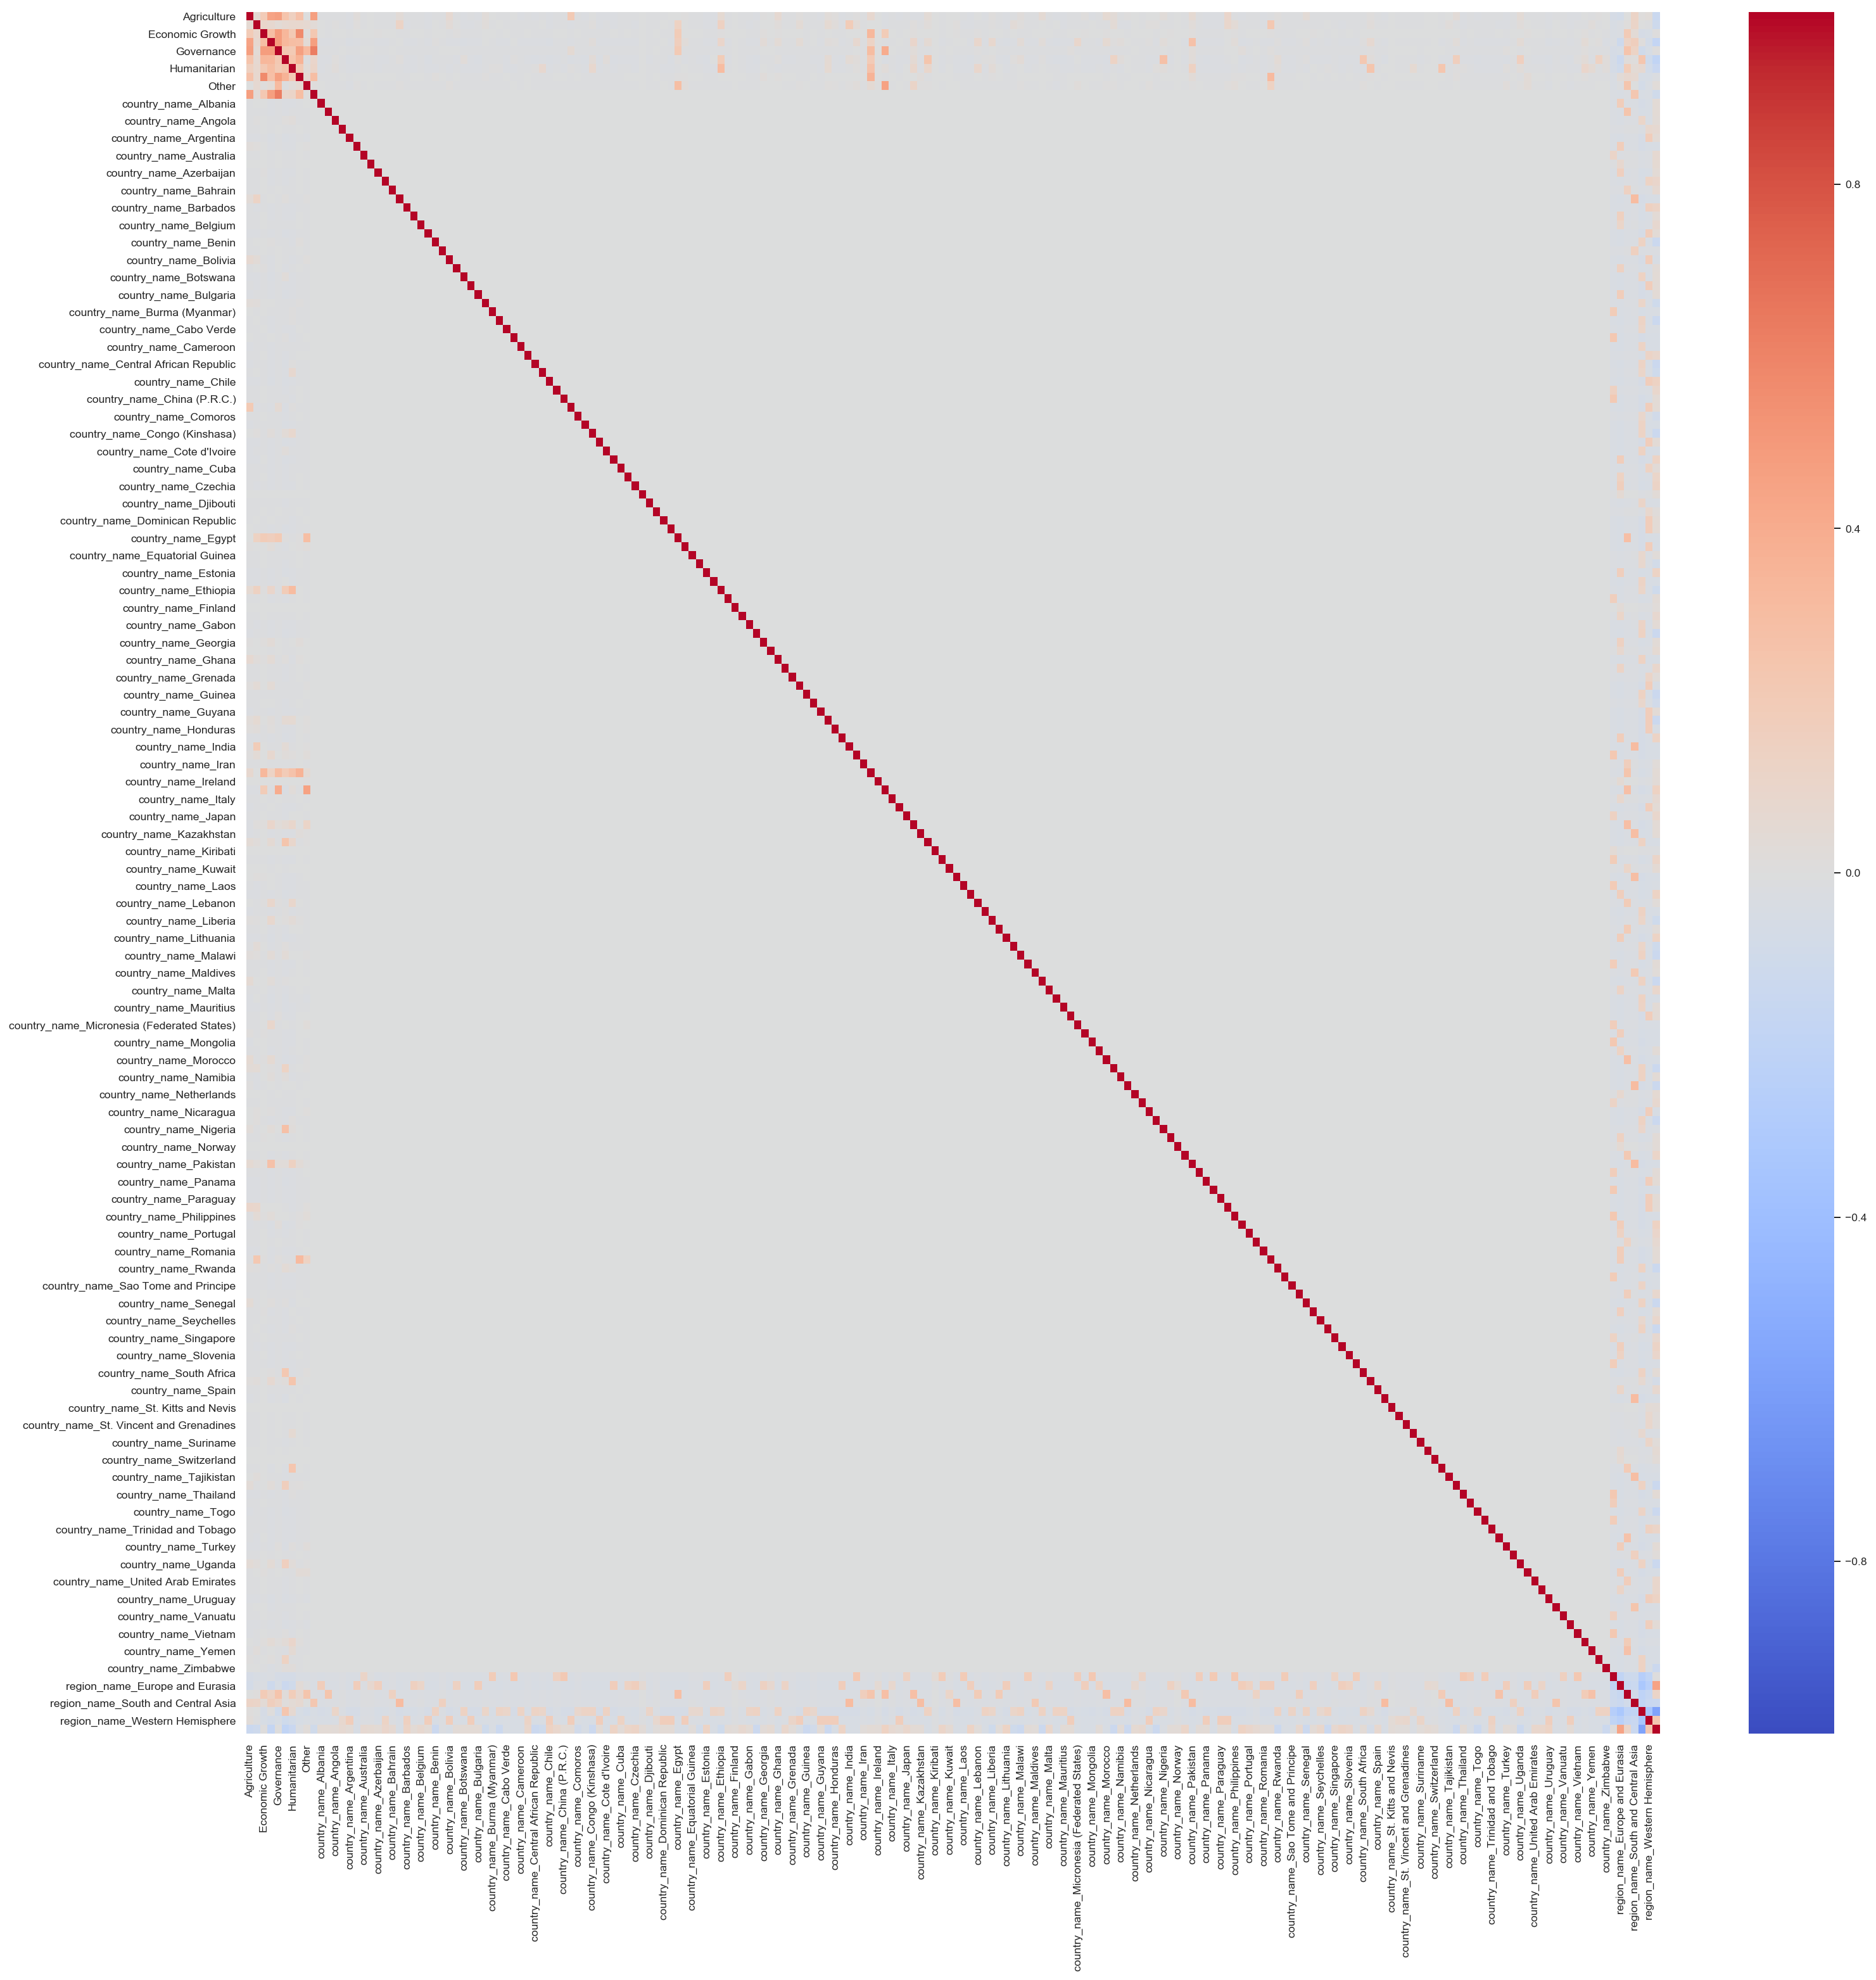

In [27]:
# Look at feature collinearity 
plt.figure(figsize=(25, 25))
sns.set_context("paper")
sns.heatmap(X.corr(), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
#plt.savefig('feature_correlation.png', bbox_inches = 'tight');

### Train/Val/Test Split

In [28]:
#Split the data 60 - 20 - 20 train/val/test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

### Standardize

In [29]:
#After train/test split, Standardize numerical features (e.g. constant_amount)
from sklearn.preprocessing import StandardScaler

scaled_train = X_train.copy()
scaled_test = X_test.copy()

col_names = ['Agriculture',
 'Commodity Assistance',
 'Economic Growth',
 'Education',
 'Governance',
 'Health and Population',
 'Humanitarian',
 'Infrastructure',
 'Other']
features_train = scaled_train[col_names]
features_test = scaled_test[col_names]

scaler = StandardScaler()
train_amount = scaler.fit_transform(features_train)
test_amount = scaler.transform(features_test)

In [30]:
X_train[col_names] = train_amount
X_test[col_names] = test_amount

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [31]:
X_train.head()

,Agriculture,Commodity Assistance,Economic Growth,Education,Governance,Health and Population,Humanitarian,Infrastructure,Other,country_name_Afghanistan,...,country_name_Yemen,country_name_Zambia,country_name_Zimbabwe,region_name_East Asia and Oceania,region_name_Europe and Eurasia,region_name_Middle East and North Africa,region_name_South and Central Asia,region_name_Sub-Saharan Africa,region_name_Western Hemisphere,Country_Income_Class
625,-0.182874,-0.272319,-0.116007,-0.262521,-0.135423,-0.291770,-0.214046,-0.132087,-0.197212,0,...,0,0,0,0,1,0,0,0,0,3
22,-0.182874,-0.272319,-0.116007,-0.262521,-0.162564,-0.289296,-0.211311,-0.058577,-0.197212,0,...,0,0,0,1,0,0,0,0,0,3
2661,-0.182874,-0.272319,-0.115933,-0.262521,-0.159990,-0.291770,-0.214046,-0.132089,-0.184893,0,...,0,0,0,0,0,0,0,1,0,2
1867,-0.182874,-0.133385,-0.116007,-0.262521,-0.162666,-0.291770,-0.214046,-0.132089,-0.181758,0,...,0,0,0,0,0,0,0,1,0,0
2036,-0.182874,-0.267167,-0.116007,-0.262521,-0.162153,-0.291770,0.071175,-0.132089,-0.196761,0,...,0,0,0,0,0,0,0,1,0,0


## Check distribution of features

In [32]:
#sns.pairplot(X, height = 1.2, aspect=1); 

In [33]:
#histogram and normal probability plot
#from scipy.stats import norm
#sns.distplot(train['HDI_change'],fit=norm);
#fig = plt.figure()
#res = stats.probplot(train['HDI_change'], plot=plt)


## Initial OLS

In [34]:
# Create OLS model
ols_model = sm.OLS(y_train, X_train)

# Fit OLS model to training set
fit = ols_model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HDI_Change   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     2.460
Date:                Wed, 19 Jun 2019   Prob (F-statistic):           2.14e-21
Time:                        13:40:50   Log-Likelihood:                 8117.1
No. Observations:                2106   AIC:                        -1.586e+04
Df Residuals:                    1918   BIC:                        -1.480e+04
Df Model:                         187                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Agriculture                                   -0.0002      0.000     -1.058      0.290      -0.000       0.000
Commodity Assistance                       -2.131e-05      0.000     -0.146      0.884      -0.000       0.000
Economic Growth                               -0.0003      0.000     -1.786      0.074      -0.001    2.98e-05
Education                                   6.729e-05      0.000      0.405      0.685      -0.000       0.000
Governance                                    -0.0002      0.000     -0.773      0.439      -0.001       0.000
Health and Population                          0.0007      0.000      4.077      0.000       0.000       0.001
Humanitarian                                  -0.0009      0.000     -5.512      0.000      -0.001      -0.001
Infrastructure                                 0.0002      0.000      1.165      0.244      -0.000       0.001
Other                                         -0.0002      0.000     -1.015      0.310      -0.000       0.000
country_name_Afghanistan                       0.0071      0.003      2.457      0.014       0.001       0.013
country_name_Albania                           0.0001      0.002      0.094      0.925      -0.003       0.003
country_name_Algeria                           0.0035      0.002      1.989      0.047    4.91e-05       0.007
country_name_Angola                            0.0036      0.002      2.072      0.038       0.000       0.007
country_name_Antigua and Barbuda              -0.0048      0.004     -1.307      0.191      -0.012       0.002
country_name_Argentina                        -0.0001      0.001     -0.080      0.936      -0.003       0.003
country_name_Armenia                           0.0031      0.002      1.905      0.057   -8.97e-05       0.006
country_name_Australia                        -0.0018      0.002     -0.788      0.431      -0.006       0.003
country_name_Austria                          -0.0006      0.003     -0.245      0.807      -0.006       0.005
country_name_Azerbaijan                        0.0032      0.001      2.113      0.035       0.000       0.006
country_name_Bahamas                          -0.0002      0.002     -0.114      0.909      -0.004       0.004
country_name_Bahrain                          -0.0027      0.003     -1.057      0.291      -0.008       0.002
country_name_Bangladesh                        0.0017      0.001      1.145      0.252      -0.001       0.005
country_name_Barbados                         -0.0013      0.001     -0.916      0.360      -0.004       0.001
country_name_Belarus                           0.0026      0.001      1.870      0.062      -0.000       0.005
country_name_Belgium                          -0.0022      0.002     -1.034      0.301

## LassoCV

In [35]:
# Run cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-4,4)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

# Best alpha value:
lasso_model.alpha_

0.0001

In [36]:
# These are the (standardized) coefficients found when it refit using that best alpha
list(zip(X_train.columns, lasso_model.coef_))

[('Agriculture', 3.1782634144268253e-05),
 ('Commodity Assistance', 4.0882119535400796e-05),
 ('Economic Growth', -0.0),
 ('Education', 0.00013188110859918618),
 ('Governance', 2.621984018493782e-05),
 ('Health and Population', 0.00046600139077783155),
 ('Humanitarian', -0.0008924799306845414),
 ('Infrastructure', 0.0),
 ('Other', -0.0),
 ('country_name_Afghanistan', 0.0),
 ('country_name_Albania', -0.0),
 ('country_name_Algeria', 0.0),
 ('country_name_Angola', 0.0),
 ('country_name_Antigua and Barbuda', -0.0),
 ('country_name_Argentina', -0.0),
 ('country_name_Armenia', 0.0),
 ('country_name_Australia', -0.0),
 ('country_name_Austria', -0.0),
 ('country_name_Azerbaijan', 0.0),
 ('country_name_Bahamas', -0.0),
 ('country_name_Bahrain', -0.0),
 ('country_name_Bangladesh', 0.0),
 ('country_name_Barbados', -0.0),
 ('country_name_Belarus', 0.0),
 ('country_name_Belgium', -0.0),
 ('country_name_Belize', -0.0),
 ('country_name_Benin', 0.0),
 ('country_name_Bhutan', 0.0),
 ('country_name_Boli

In [37]:
# Make predictions on the test set using the model
test_set_pred = lasso_model.predict(X_test)

# Evaluation:
r2_score(y_test, test_set_pred)

-0.012351778925530743

## RidgeCV

In [38]:
ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_train, y_train)

list(zip(X_train.columns, ridge_model.coef_))

[('Agriculture', -8.430193304150333e-05),
 ('Commodity Assistance', 7.878589309863845e-05),
 ('Economic Growth', -0.00025034379096489274),
 ('Education', 0.00010546500180740012),
 ('Governance', 0.0001452289427366285),
 ('Health and Population', 0.0006990036859041566),
 ('Humanitarian', -0.0009745504786913369),
 ('Infrastructure', 0.0001322035642238967),
 ('Other', -0.0001275429915483875),
 ('country_name_Afghanistan', 0.0010370656412886487),
 ('country_name_Albania', -0.00021961125972963036),
 ('country_name_Algeria', 0.001339731400402705),
 ('country_name_Angola', 0.0016916042367967343),
 ('country_name_Antigua and Barbuda', -0.0007332815427217543),
 ('country_name_Argentina', -0.00029589060047305896),
 ('country_name_Armenia', 0.001027252636049403),
 ('country_name_Australia', -0.0005401958479851878),
 ('country_name_Austria', -0.0002448067251763945),
 ('country_name_Azerbaijan', 0.0013704369401143814),
 ('country_name_Bahamas', -0.00014546274716334496),
 ('country_name_Bahrain', -0

In [39]:
# Make predictions on the test set using the model
test_set_pred = ridge_model.predict(X_test)

# Evaluation:
r2_score(y_test, test_set_pred)

-0.009152768472590944

## RandomForestRegressor

In [40]:
#from sklearn.model_selection import cross_val_score, GridSearchCV
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.preprocessing import MinMaxScaler

In [41]:
#gsc = GridSearchCV(estimator=RandomForestRegressor(), 
#                   param_grid={
#                       'max_depth': range(3,7), 
#                       'n_estimators': (10, 50, 100, 1000)}, 
#                   cv=5, scoring='neg_mean_squared_error', 
#                   verbose=0, n_jobs=-1)

#grid_result = gsc.fit(X_train, y_train)
#best_params = grid_result.best_params_

In [42]:
#rfr_model = RandomForestRegressor(max_depth=best_params["max_depth"], 
#                                  n_estimators=best_params["n_estimators"], 
#                                  random_state=42, verbose=False)

#rfr_model.fit(X_train, y_train)

In [43]:
# Make predictions on the test set using the model
#rfr_test_set_pred = rfr_model.predict(X_test)

# Evaluation:
#r2_score(y_test, rfr_test_set_pred)

## XGBoost

In [44]:
import xgboost as xgb

In [45]:
#Evaluate models with Root Mean Squared Error
def rmse(actuals, preds):
    return np.sqrt(((actuals - preds) ** 2).mean())

In [46]:
gbm = xgb.XGBRegressor(n_estimators=300000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8)

In [47]:
eval_set=[(X_train, y_train),(X_val, y_val)] #tracking train/validation error as we go
fit_model = gbm.fit(X_train, y_train, 
                    eval_set=eval_set, 
                    eval_metric='rmse', 
                    early_stopping_rounds=20, 
                    verbose=True)


[0]	validation_0-rmse:0.445674	validation_1-rmse:0.445131
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.401134	validation_1-rmse:0.400593
[2]	validation_0-rmse:0.361048	validation_1-rmse:0.360507
[3]	validation_0-rmse:0.32497	validation_1-rmse:0.32443
[4]	validation_0-rmse:0.292499	validation_1-rmse:0.291959
[5]	validation_0-rmse:0.263274	validation_1-rmse:0.262734


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[6]	validation_0-rmse:0.236973	validation_1-rmse:0.236433
[7]	validation_0-rmse:0.2133	validation_1-rmse:0.212761
[8]	validation_0-rmse:0.191997	validation_1-rmse:0.191458
[9]	validation_0-rmse:0.172824	validation_1-rmse:0.172285
[10]	validation_0-rmse:0.15557	validation_1-rmse:0.155031
[11]	validation_0-rmse:0.140043	validation_1-rmse:0.139504
[12]	validation_0-rmse:0.12607	validation_1-rmse:0.125531
[13]	validation_0-rmse:0.113495	validation_1-rmse:0.112957
[14]	validation_0-rmse:0.102182	validation_1-rmse:0.101644
[15]	validation_0-rmse:0.092002	validation_1-rmse:0.091464
[16]	validation_0-rmse:0.082844	validation_1-rmse:0.082307
[17]	validation_0-rmse:0.074605	validation_1-rmse:0.074068
[18]	validation_0-rmse:0.067194	validation_1-rmse:0.066658
[19]	validation_0-rmse:0.060529	validation_1-rmse:0.059994
[20]	validation_0-rmse:0.054536	validation_1-rmse:0.054001
[21]	validation_0-rmse:0.049148	validation_1-rmse:0.048614
[22]	validation_0-rmse:0.044305	validation_1-rmse:0.043773
[23]	

In [48]:
fit_model_pred = fit_model.predict(X_test)

In [49]:
#accuracy_score(y_test, fit_model_pred)

In [50]:
rmse(y_test, fit_model_pred)

0.006260118260748254

In [51]:
r2_score(y_test, fit_model_pred)

-0.0724837805209344

In [52]:
#To tune, we should use validation results and ignore test until 
#final verification. So here's the validation error benchmark we want to beat:
#rmse(gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit),y_val) 

In [53]:
#### Standard Scaling

#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

## This step fits the Standard Scaler to the training data
## Essentially it finds the mean and standard deviation of each variable in the training set

#std = StandardScaler()
#std.fit(X_train.values)

## This step applies the scaler to the train set.
## It subtracts the mean it learned in the previous step and then divides by the standard deviation

#X_tr = std.transform(X_train.values)

## Apply the scaler to the test set

#X_te = std.transform(X_test.values)